***Ante Scriptum***: We love the following command in a Notebook

In [1]:
%reset -f
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Context

This notebook resumes the work of **Paul Peseux** & **Clément Benesse** done for the Machine Learning course of M.Garivier at the ENS de Lyon.

We participated to an [IA Challenge](http://defi-ia.insa-toulouse.fr/).
It is about binary classification on image. The data, provided by airbus, is made of pictures taken from the sky. 

The objective is to determine if there is or not a Wind Turbine on the provided picture.

As the data set is balanced, the metric used to rank submissions is _accuracy_.


For its simplicity and its performances, we decided to use **Keras** to build our models and test them.

Everything was run locally on a MacBook Pro 2016.

The Notebook is organized as follow

**- 1. Data loading and preprocessing**

**- 2. Model creation**

**- 3. Training**

**- 4. Submission**

**- 5. Analysis in order to tune the model**


# 1. Data loading and preprocessing

## Lets import some useful packages

In [2]:
import warnings
warnings.filterwarnings("ignore") # We know it is bad, but still, it is better to present a Notebook
import random
import numpy as np
import pandas as pd
from keras.models import Sequential, model_from_json, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.initializers import RandomNormal as RN
from keras.utils.vis_utils import model_to_dot
from utils import *
import os 
from os import system
from IPython.display import SVG
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, roc_curve

Using TensorFlow backend.


## Some parameters

Here are the basic parameters to load data.

The image are square with $128 \times 128$ pixels. 
Here is a representation found on the [web](https://fr.mathworks.com/help/matlab/ref/image.html).
![Figure](cdata_colormodels.png)

In [3]:
size = 128
data_train_path_target = "data_airbus_defi/train/"
data_test_path = "data_airbus_defi/test/"
input_shape = (size, size, 3)

## Loading data as  numpy arrays

In [4]:
XTRAIN, train_label1, x_test = loadDATA(PATH=os.getcwd(),full=True, some=False, little=30000)
system('say Data chargée!')
print("Data chargée!")
print("Input data shape : ")
print(XTRAIN.shape)

Data chargée!
Input data shape : 
(68218, 128, 128, 3)


## Suffling data
Not (totally) sure it is useful. As **Keras** might do it itself.

We shuffle them as we do not know how there are given by the challenge.

Quite long when we use every data

In [5]:
XTRAIN, train_labels = unison_shuffled_copies(XTRAIN,train_label1)
system('say Data mélangée!')
print("Data mélangée!")

Data mélangée!


# 2. Model creation

## Model generator

In [6]:
def cnn(n_layers, MIN_NEURONS=8, MAX_NEURONS=32, KERNEL=(3,3), dropout=.5, leaky=True, alpha=.1):
    global input_shape
    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)
    model = Sequential()
    for i in range(0, n_layers):
        if i == 0:
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=input_shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))
        if leaky:
            model.add(LeakyReLU(alpha=alpha))
        else:
            model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    if leaky:
        model.add(LeakyReLU(alpha=alpha))
    else:
        model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

We use a _linear_ network.

To deal with  image, the most common way is to use Convolutional Neural Network. To illustrate it we foud a great picture [here](https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/).

![FigureCNN](CNN.png)

We decided to work with $3$ convolutional layers.

In [7]:
modelCNN = cnn(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 16)      1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 24)      3480      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 122, 122, 24)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 24)        0         
__________

## Another model. With bare hands.

In [21]:
trained = True

epochs = 5
validation_split = .1
conv2Dsize = 32
pool_size = (3,3)
fulSize = 16
dropout = .5

if not trained:
    modelBW = Sequential()
    modelBW.add(Conv2D(conv2Dsize, (4,4), input_shape = input_shape, activation = 'relu'))
    modelBW.add(Conv2D(12, pool_size, activation = 'relu'))
    modelBW.add(Conv2D( 6, (2,2), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = (2,2)))
    modelBW.add(Dropout(dropout))
    modelBW.add(Conv2D(conv2Dsize, (3, 3), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = pool_size))
    modelBW.add(Dropout(dropout))
    modelBW.add(Flatten())
    modelBW.add(Dense(units = fulSize, activation = 'sigmoid'))
    modelBW.add(Dense(units = 1, activation = 'sigmoid'))

    modelBW.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    modelBW.summary()
else:
    modelBW = loadModel("2018-11-06 13:52")
    modelBW.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    #modelBW.summary()



Loaded model from disk


# 3. Training

Once the model is generated, we have to train **it** !

## Learning

In [14]:
shufflingTimes = 1
epochs = 2**2 #We love powers of 2
validation_split = .4
batch_size = 2**5 #We love powers of 2
for i in range(shufflingTimes):
    history = modelCNN.fit(XTRAIN, train_labels, epochs=epochs, verbose=1, validation_split=validation_split, batch_size=batch_size)
    if i < shufflingTimes - 1:
        XTRAIN, train_labels = unison_shuffled_copies(XTRAIN,train_labels)

Train on 40930 samples, validate on 27288 samples
Epoch 1/4
40930/40930 [==============================] - 1631s 40ms/step - loss: 0.2426 - acc: 0.9039 - val_loss: 0.1857 - val_acc: 0.9307
Epoch 2/4
40930/40930 [==============================] - 1880s 46ms/step - loss: 0.1635 - acc: 0.9384 - val_loss: 0.1553 - val_acc: 0.9417
Epoch 3/4
40930/40930 [==============================] - 1633s 40ms/step - loss: 0.1249 - acc: 0.9542 - val_loss: 0.1496 - val_acc: 0.9459
Epoch 4/4
40930/40930 [==============================] - 1641s 40ms/step - loss: 0.0980 - acc: 0.9644 - val_loss: 0.1685 - val_acc: 0.9471


We tried something with shuffling the data we were training on, but it only led to overfitting. We let the trace of this bad idea in the code on purpose.

In [11]:
#history = modelBW.fit(XTRAIN, train_labels, epochs=epochs, verbose=1, validation_split=validation_split, batch_size=16)

We plot the learning evolution of our model.

We used [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) which was not convenient for sharing (the way we used it).

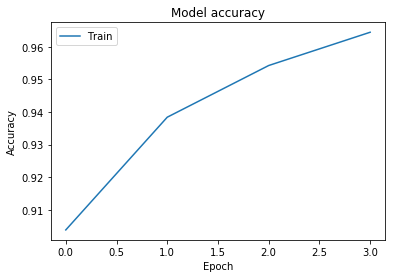

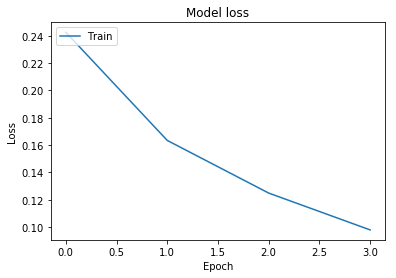

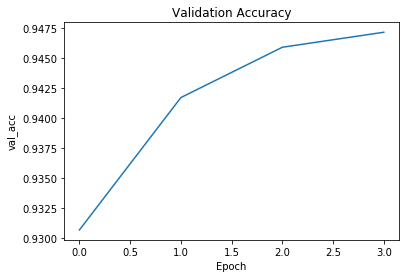

In [15]:
plotLearning(history)

# 4. Submission

## Prediction

In [34]:
prediction, predictionProba = prediction_from_model(modelCNN,x_test)
predictionTRAIN, predictionProbaTRAIN = prediction_from_model(modelCNN,XTRAIN, threshold=.45)

some predictions
[1, 0, 1, 0, 1, 1, 0, 1, 1]
some predictions
[1, 0, 1, 0, 0, 1, 0, 1, 1]


## Writting output

In [14]:
today = str(datetime.today())[:16]
soumissionCSV(prediction, today,PATH=os.getcwd())
system('say On est bon!')

CSV file written


0

In [15]:
print("Proportion of windmills")
sum(prediction)/ len(prediction)

Proportion of windmills


0.431578330206379

In [16]:
saveModel(modelCNN, today)

Saved model


## Vizualize submission

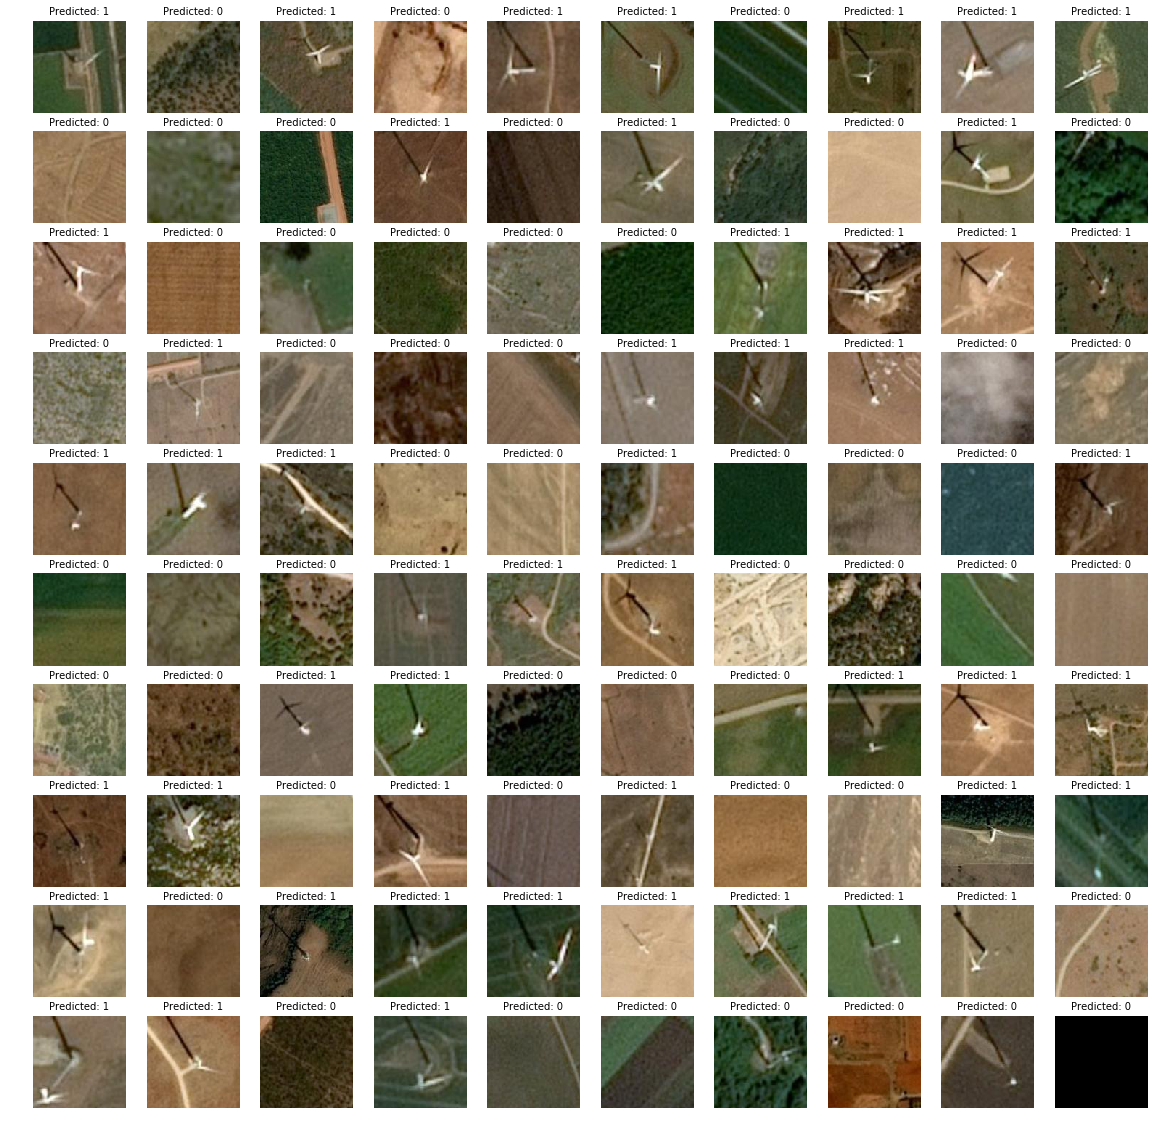

In [37]:
size = 100
visualize_incorrect_labels(x_test[:size], prediction[:size], title="Predicted: ")

# 5. Analysis in order to tune the model

## Improving model

Our neural Network returns an estimated probability:
$$
model(image) = \mathbb{P} (\mathbf{1}_{\text{there is a wind turbine}})
$$

But on our submission we have to return $1$ or $0$. As a consequence we need to define a function
$$
f\colon\begin{cases}
[0,1] \longrightarrow \{0,1\}\\
\ \ \ x \ \ \ \ \longmapsto \ \ f(x)
\end{cases}
$$
The basic one we can think of is a threshold function:
$$
f_\theta\colon\begin{cases}
[0,1] \longrightarrow \{0,1\}\\
\ \ \ x \ \ \ \ \longmapsto \ \ \mathbb{1}_{x>\theta}
\end{cases}
$$

The logical $\theta$ would be $\theta = \frac{1}{2}$

But thanks to the analysis we decided to go for $\theta = 0.56$


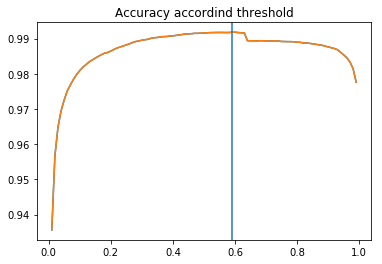

0.59

In [20]:
predproba = [p[0] for p in predProbaTRAIN]
labels = [t for t in train_labels]
findThreshod(predproba,labels)

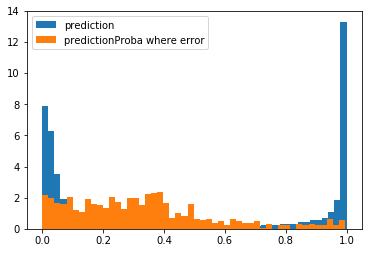

In [40]:
probaerrors = probaErrors(predictionTRAIN, predictionProbaTRAIN, train_labels)

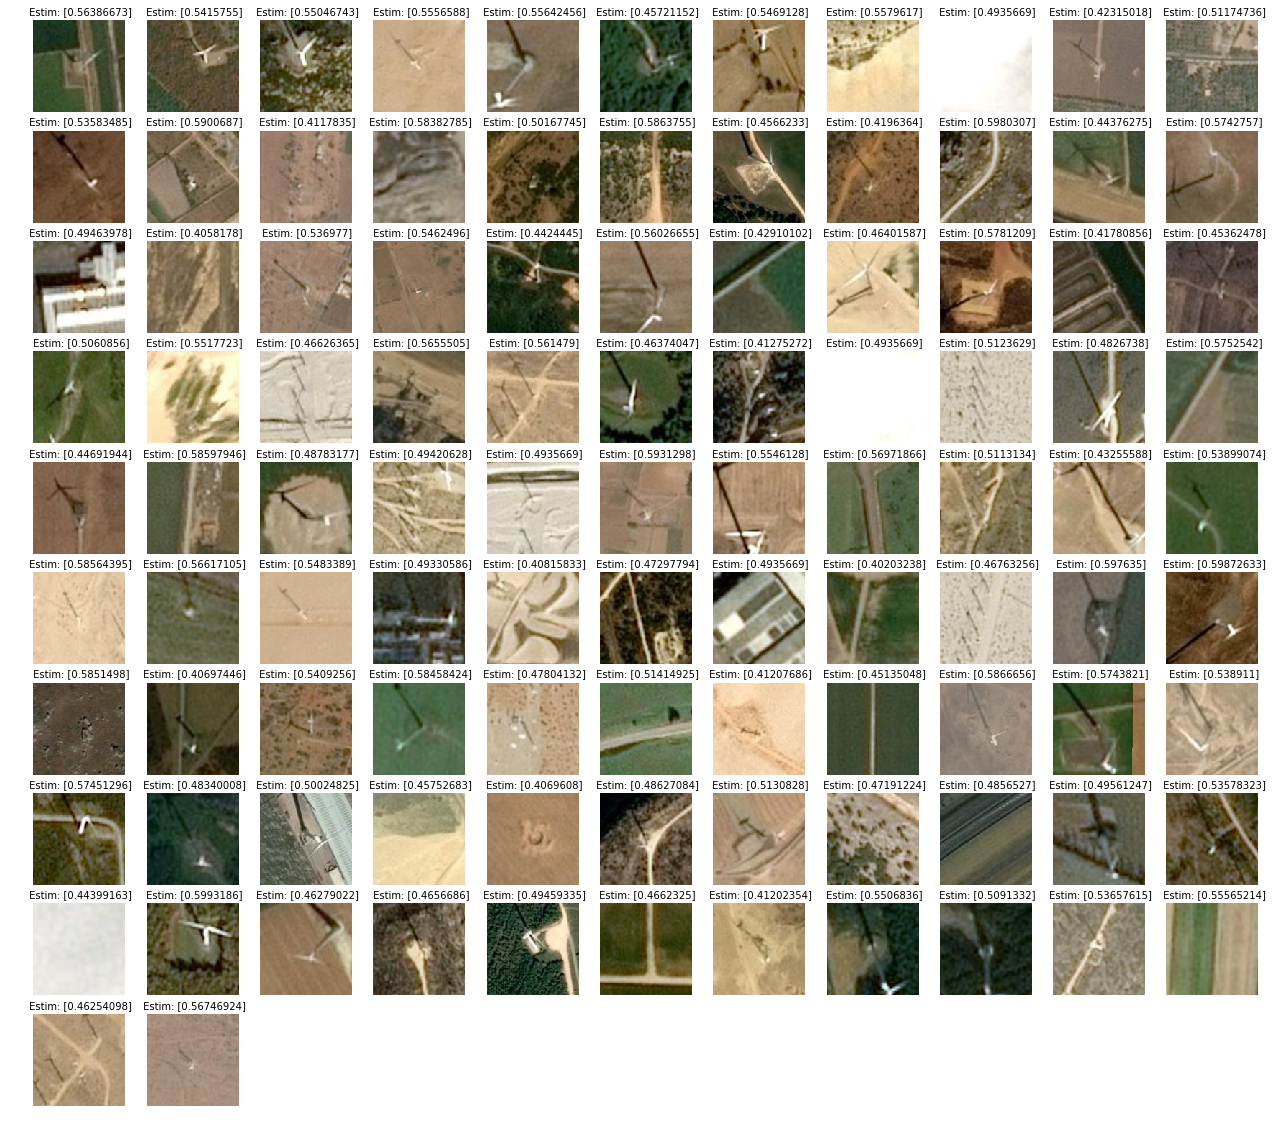

In [26]:
visualizeUncertainLabels(x_test, predictionProba,.10)

We also decided to plot the errors remaining in the train-dataset. 
By looking for those mistakes we understand 3 things
- There are some label mistake in the train dataset which might not help for learning. At least in some cases we (humans) are not able to say if there is one wind turbine or not. 
- Our model does not detect wind turbines shadows
- Our model is not good to detect wind turbines on sizes and corners of the image.

Some improvement could be done by working on relabeling the dataset by removing mistakes, and retrain the model.

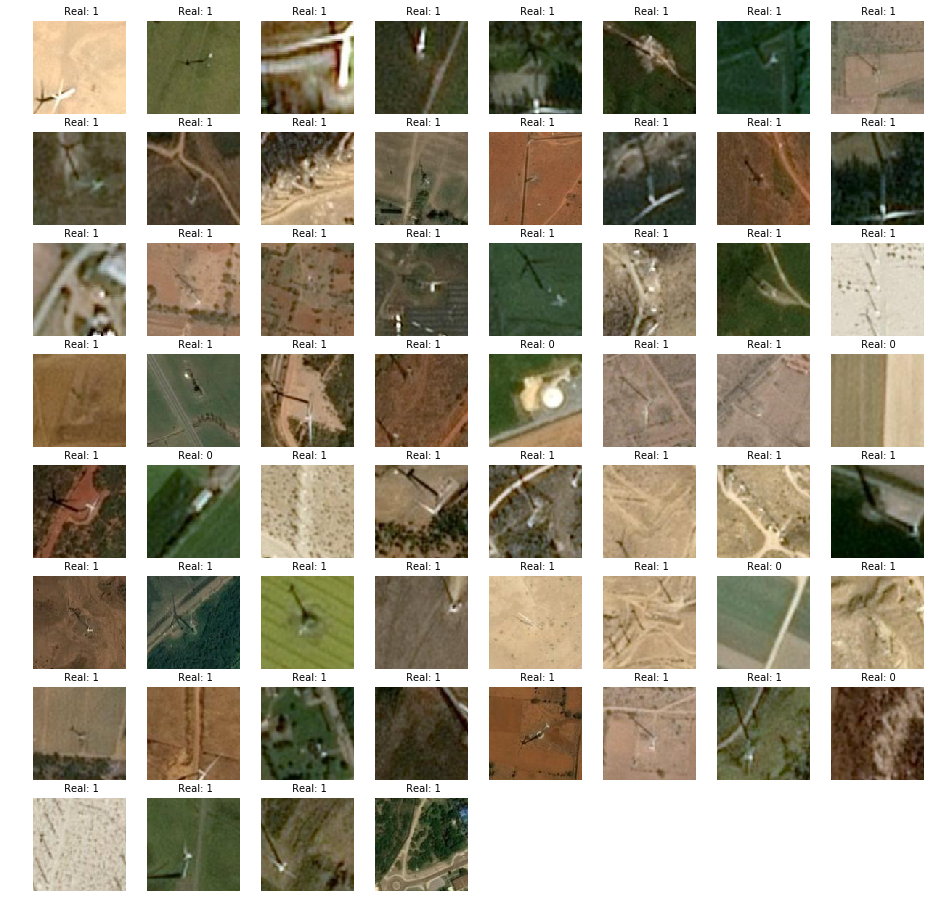

In [29]:
Xvizu, labs = lastErrors(XTRAIN,train_labels,modelCNN)
visualize_incorrect_labels(Xvizu, labs)

From what we understood, if there is only a shadow and the wind turbine is not in the picture, it is labeled as 1.

As soon as it is the same thing in _train_ and _test_ dataset, it is fine.

To finally return a submission file, we took different submissions, trained on _different_ dataset and we used a simple vote decision.
As we had more false negative than false positive, we tried with the max $estim = \underset{c \in \mathbb{C}}{\max} estim_c $. As soon a classifier says that there is a wind turbines, we say yes.

With $3$ classifiers, it works well.
Of course if we do that with $n >> 1$ classifiers, we could use a threshold vote rule, as $1$ if and only if more that $\alpha \%$ say that there is a wind turbine

---------

## Loading old models

In [9]:
loadedModel = loadModel("2018-11-03 18:09")
pred, predProba = prediction_from_model(loadedModel,x_test)


Loaded model from disk
some predictions
[1, 0, 1, 0, 1, 1, 0, 1, 1]


-------

## ROC CURVE

In [10]:
predTRAIN, predProbaTRAIN = prediction_from_model(loadedModel,XTRAIN)

some predictions
[0, 0, 1, 0, 1, 0, 0, 0, 1]


In [ ]:
def plotROC(train_lab, predprobatrain):
    fpr, tpr, _ = roc_curve(train_lab, predprobatrain)
    plt.plot(fpr,tpr)
    plt.title("Une courbe ROC à faire palir des classifieurs")
    plt.show()
    plt.close()
    return True
plotROC(train_labels, predProbaTRAIN)

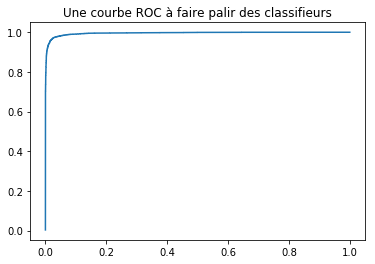

In [33]:
fpr, tpr, _ = roc_curve(train_labels, predProbaTRAIN)
plt.plot(fpr,tpr)
plt.title("Une courbe ROC à faire palir des classifieurs")
plt.show()

## One model that was good

In [ ]:
epochs = 50
validation_split = .1
conv2Dsize = 12
pool_size = (2,2)


modelBW = Sequential()
modelBW.add(Conv2D(conv2Dsize, (5), 
                  padding="same", 
                  input_shape=input_shape))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

# second set of CONV => RELU => POOL layers
modelBW.add(Conv2D(conv2Dsize, (5, 5), padding="same"))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
#model.add(Dropout(0.2)) ???



#first (and only) set of FC => RELU layers
modelBW.add(Flatten())
modelBW.add(Dense(2))
modelBW.add(Activation("sigmoid"))

# softmax classifier
modelBW.add(Dense(1))
modelBW.add(Activation("relu"))
modelBW.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['accuracy'])

